Number of trades executed: 25
Final portfolio value: $10021.84


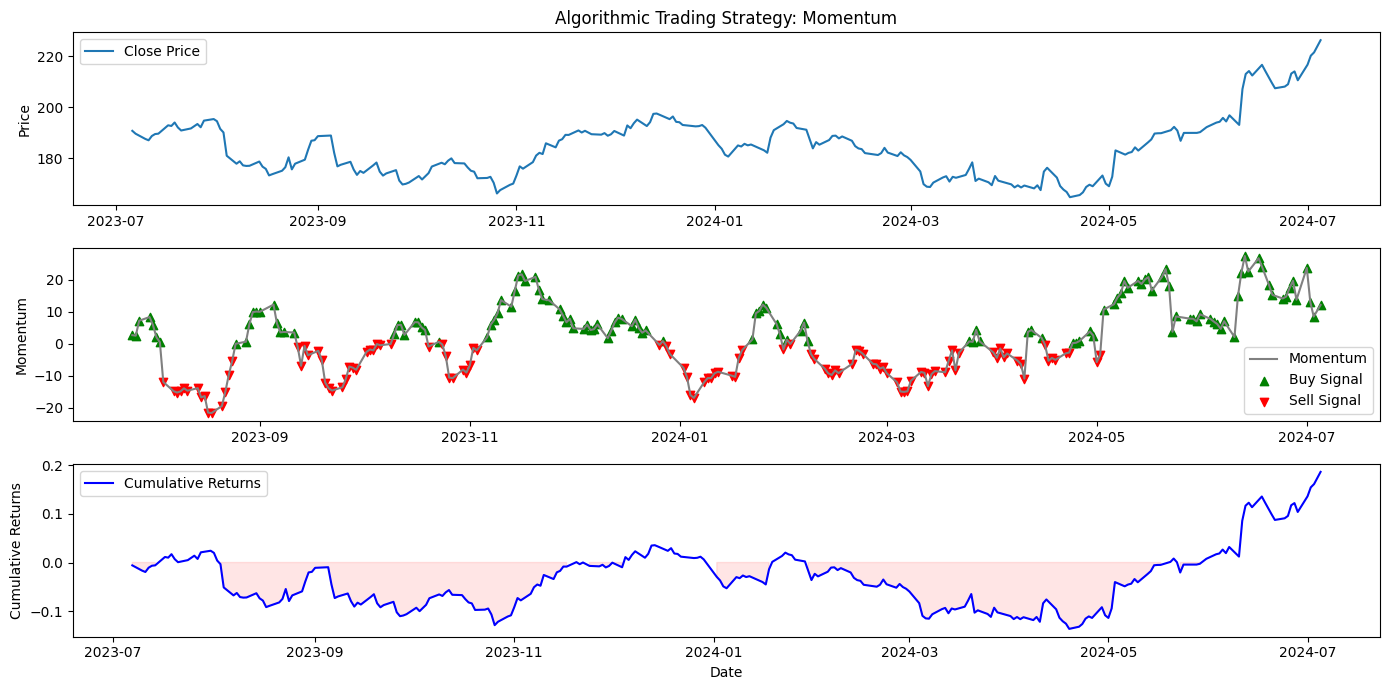

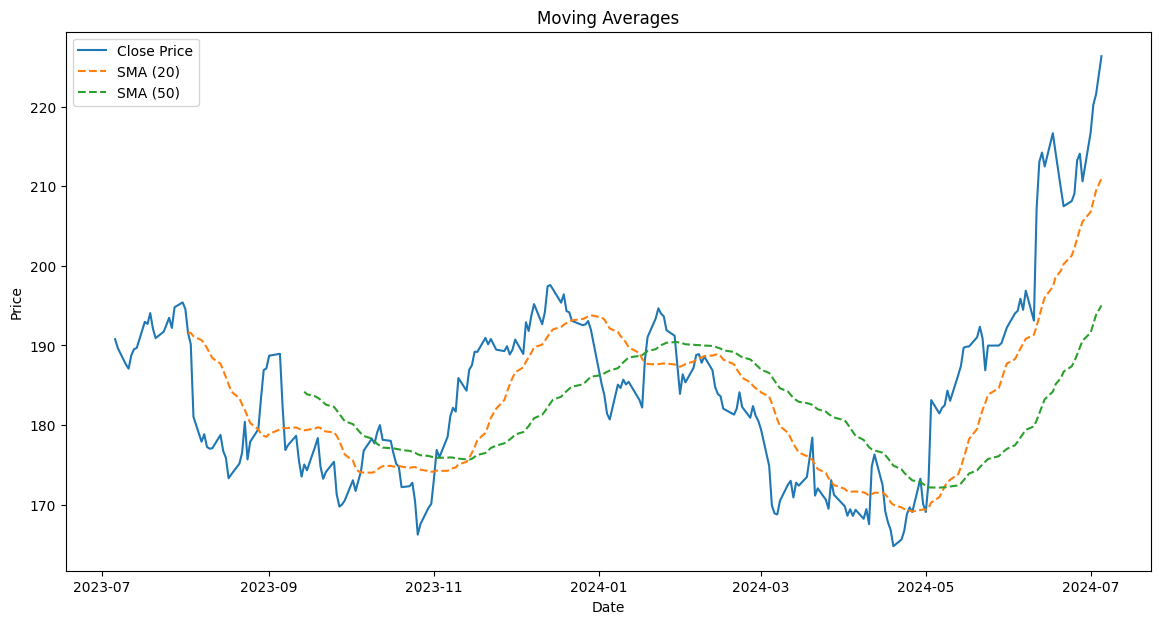

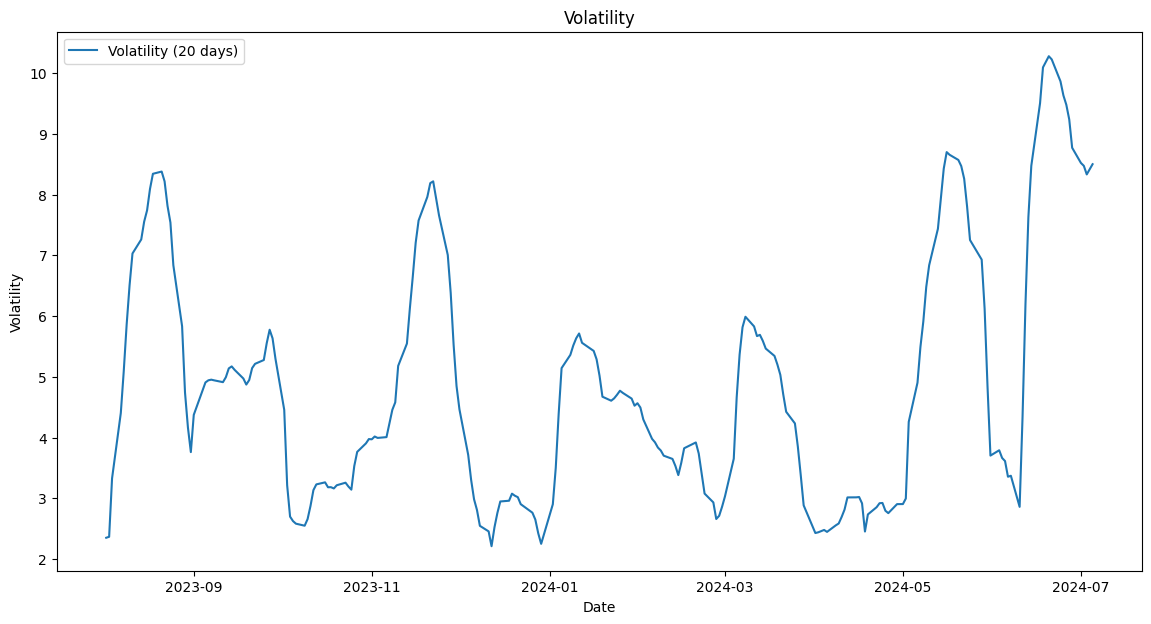


Statistical Summary:
             Open        High         Low       Close        Volume  \
count  252.000000  252.000000  252.000000  252.000000  2.520000e+02   
mean   184.060145  185.674655  182.604873  184.169842  6.038418e+07   
std     11.629600   11.858087   11.529363   11.755700  2.472741e+07   
min    165.126031  166.174602  163.857753  164.776505  2.404830e+07   
25%    174.586992  176.548839  173.115333  174.801842  4.678918e+07   
50%    183.369092  184.939677  181.643625  183.502808  5.373395e+07   
75%    190.981728  192.459847  189.739489  191.044178  6.615335e+07   
max    221.649994  226.449997  221.649994  226.339996  2.464214e+08   

        Dividends  Stock Splits    Momentum  Daily_Return  Cumulative_Return  \
count  252.000000         252.0  238.000000    251.000000         251.000000   
mean     0.003849           0.0    1.388450      0.000777          -0.034871   
std      0.030374           0.0   10.421292      0.013962           0.061698   
min      0.000000 

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Function to calculate momentum
def calculate_momentum(data, n=14):
    """
    Function to calculate n-period momentum
    """
    data['Momentum'] = data['Close'].diff(n)
    return data

# Function to generate signals
def generate_signals(data):
    """
    Function to generate buy/sell signals based on momentum
    """
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    signals['Momentum'] = data['Momentum']
    
    # Generate buy signals (if momentum > 0)
    signals.loc[data['Momentum'] > 0, 'signal'] = 1.0
    
    # Generate sell signals (if momentum < 0)
    signals.loc[data['Momentum'] < 0, 'signal'] = -1.0
    
    return signals

# Function to backtest the strategy
def backtest_strategy(data, signals, initial_capital=10000):
    """
    Function to backtest the trading strategy
    """
    capital = initial_capital  # Starting capital
    position = 0  # 0 means no position, 1 means long (buy), -1 means short (sell)
    trades = []
    portfolio_value = []
    
    for i in range(len(signals)):
        price = data.iloc[i]['Close']
        signal = signals.iloc[i]['signal']
        
        if signal == 1.0 and position == 0:
            # Buy signal and no existing position, execute buy
            position = 1
            capital -= price  # Deduct price from capital
            trades.append((data.index[i], 'Buy', price))
        elif signal == -1.0 and position == 1:
            # Sell signal and long position, execute sell
            position = 0
            capital += price  # Add price to capital
            trades.append((data.index[i], 'Sell', price))
        
        # Store portfolio value at each time step
        portfolio_value.append(capital + (position * price))
    
    # Calculate final portfolio value
    final_value = capital + (position * data.iloc[-1]['Close'])
    
    return trades, final_value, portfolio_value

# Function to calculate and plot moving averages
def plot_moving_averages(data, window_short=20, window_long=50):
    """
    Function to calculate and plot moving averages
    """
    data['SMA_short'] = data['Close'].rolling(window=window_short).mean()
    data['SMA_long'] = data['Close'].rolling(window=window_long).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Close Price')
    plt.plot(data.index, data['SMA_short'], label='SMA ({})'.format(window_short), linestyle='--')
    plt.plot(data.index, data['SMA_long'], label='SMA ({})'.format(window_long), linestyle='--')
    plt.title('Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()

# Function to plot volatility (rolling standard deviation)
def plot_volatility(data, window=20):
    """
    Function to plot volatility (rolling standard deviation)
    """
    data['Volatility'] = data['Close'].rolling(window=window).std()
    
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Volatility'], label='Volatility ({} days)'.format(window))
    plt.title('Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend(loc='best')
    plt.show()

# Function to print statistical summary
def print_statistical_summary(data):
    """
    Function to print statistical summary of the data
    """
    print("\nStatistical Summary:")
    print(data.describe())

# Main function to integrate all components
def main():
    # Fetch historical data from Yahoo Finance
    stock = yf.Ticker("AAPL")
    data = stock.history(period="1y")
    
    # Calculate momentum with a 14-day period
    data = calculate_momentum(data, n=14)
    
    # Generate buy/sell signals based on momentum
    signals = generate_signals(data)
    
    # Backtest the strategy
    trades, final_value, portfolio_value = backtest_strategy(data, signals)
    
    # Print the summary of trades and final portfolio value
    print("Number of trades executed:", len(trades))
    print("Final portfolio value: ${:.2f}".format(final_value))
    
    # Plotting
    plt.figure(figsize=(14, 7))
    
    # Plotting close price
    plt.subplot(3, 1, 1)
    plt.plot(data.index, data['Close'], label='Close Price')
    plt.title('Algorithmic Trading Strategy: Momentum')
    plt.ylabel('Price')
    plt.legend(loc='best')
    
    # Plotting momentum and buy/sell signals
    plt.subplot(3, 1, 2)
    plt.plot(data.index, data['Momentum'], label='Momentum', color='grey')
    plt.scatter(signals.loc[signals['signal'] == 1.0].index, data.loc[signals['signal'] == 1.0]['Momentum'], marker='^', color='g', label='Buy Signal')
    plt.scatter(signals.loc[signals['signal'] == -1.0].index, data.loc[signals['signal'] == -1.0]['Momentum'], marker='v', color='r', label='Sell Signal')
    plt.ylabel('Momentum')
    plt.legend(loc='best')
    
    # Plotting cumulative returns and drawdowns
    plt.subplot(3, 1, 3)
    data['Daily_Return'] = data['Close'].pct_change()
    data['Cumulative_Return'] = (1 + data['Daily_Return']).cumprod() - 1
    plt.plot(data.index, data['Cumulative_Return'], label='Cumulative Returns', color='blue')
    plt.fill_between(data.index, 0, data['Cumulative_Return'], where=data['Cumulative_Return'] < 0, alpha=0.1, color='red')
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # Additional Analysis
    plot_moving_averages(data)
    plot_volatility(data)
    print_statistical_summary(data)

if __name__ == "__main__":
    main()
